In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 50)
# pd.set_option('display.max_rows', 50)
import tabula
from pandasql import sqldf
import math
from scipy.stats import chi2
from scipy import stats
from matplotlib import pyplot as plt

--DNA layer

In [2]:
# import dataset
dna_layer = pd.read_excel(r'C:\Users\edwar\Desktop\農藝\paper2\metaData_soybean_drought.xlsx', sheet_name = 'DNA')

In [3]:
# import template
template_a2v2 = pd.read_csv(r'C:\Users\edwar\Desktop\農藝\paper2\Glyma2.0_mapping.txt', delimiter = '\t')
template_a1v11 = pd.read_csv(r'C:\Users\edwar\Desktop\農藝\paper2\Glyma1.1_mapping.txt', delimiter = '\t')
template_a1v10 = pd.read_csv(r'C:\Users\edwar\Desktop\農藝\paper2\Glyma1.0_mapping.txt', delimiter = '\t')
template_a2v2['bp0'] = template_a2v2['bp0'].apply(lambda x : x - 20000)
template_a1v11['bp0'] = template_a1v11['bp0'].apply(lambda x : x - 20000)
template_a1v10['bp0'] = template_a1v10['bp0'].apply(lambda x : x - 20000)
template_a2v2['bp1'] = template_a2v2['bp1'].apply(lambda x : x + 20000)
template_a1v11['bp1'] = template_a1v11['bp1'].apply(lambda x : x + 20000)
template_a1v10['bp1'] = template_a1v10['bp1'].apply(lambda x : x + 20000)

In [4]:
gene_already = dna_layer[dna_layer['mapped_gene'].isna() == False]

In [5]:
gene_mapped = dna_layer[dna_layer['mapped_gene'].isna()].reset_index().drop(['index'], axis = 1)

In [6]:
gene_mapped_v1 = gene_mapped[['marker', 'mapped_gene', 'chr', 'bp0', 'bp1', 'p', 'gene_version', 'article_name']]

In [7]:
gene_mapped_v1.head()

,marker,mapped_gene,chr,bp0,bp1,p,gene_version,article_name
0,ss715579324,NaN,1,4015639.0,4015639.0,0.000007,2.0,Genome-Wide Association Analyses Reveal Genomi...
1,ss715580187,NaN,1,51961463.0,51961463.0,0.000017,2.0,Genome-Wide Association Analyses Reveal Genomi...
2,ss715581823,NaN,2,3165348.0,3165348.0,0.000005,2.0,Genome-Wide Association Analyses Reveal Genomi...
3,ss715582842,NaN,2,42073473.0,42073473.0,0.000019,2.0,Genome-Wide Association Analyses Reveal Genomi...
4,ss715588277,NaN,4,46096228.0,46096228.0,0.000010,2.0,Genome-Wide Association Analyses Reveal Genomi...


In [8]:
gene_mapped = dna_layer[dna_layer['mapped_gene'].isna()].reset_index().drop(['index'], axis = 1)
gene_mapped_v1 = gene_mapped[['marker', 'methodology', 'mapped_gene', 'chr', 'bp0', 'bp1', 'p', 'lod', 'gene_version', 'article_name']]
article_list = list((gene_mapped_v1['article_name'].unique()))
mapped_gene_data = pd.DataFrame()

def gene_mapping_ver(df, template, i):
    cri1 = (df.iloc[i]['bp0'] - template['bp0']) * (df.iloc[i]['bp0'] - template['bp1']) <= 0
    cri2 = (df.iloc[i]['bp1'] - template['bp1']) * (df.iloc[i]['bp1'] - template['bp0']) <= 0
    cri3 = (df.iloc[i]['bp1'] < template['bp1']) & (df.iloc[i]['bp0'] > template['bp0'])
    cri4 = (df.iloc[i]['chr'] == template['chr'])
    return template[((cri1 | cri2) | cri3) & (cri4)].reset_index().drop(['index'], axis = 1)


for j in range(len(article_list)):
    # mapped gene by individual aticle 
    gene_mapped_paper = gene_mapped_v1[gene_mapped_v1['article_name'] == article_list[j]]

    # classified marker data via Glyma version
    marker_v2 = gene_mapped_paper[gene_mapped_paper['gene_version'] == 2.0]
    marker_v11 = gene_mapped_paper[gene_mapped_paper['gene_version'] == 1.1]
    marker_v10 = gene_mapped_paper[gene_mapped_paper['gene_version'] == 1.0]

    # create each dataset based on gene version
    if marker_v2.empty:
        gene_v2 = pd.DataFrame()
    else:
        gene_v2 = pd.DataFrame()
        for i in range(len(marker_v2['marker'])):
            gene_v2_temp = pd.DataFrame()
            gene_v2_temp = gene_mapping_ver(marker_v2, template_a2v2, i)
            gene_v2_temp['marker'] = marker_v2.iloc[i]['marker']
            gene_v2_temp['p'] = marker_v2.iloc[i]['p']
            gene_v2_temp['lod'] = marker_v2.iloc[i]['lod']
            gene_v2_temp['article_name'] = article_list[j]
            gene_v2_temp['gene_version'] = 2
            gene_v2_temp['methodology'] = marker_v2.iloc[i]['methodology']
            gene_v2 = pd.concat([gene_v2, gene_v2_temp]).reset_index().drop(['index'], axis = 1)
            
    if marker_v11.empty:
        gene_v11 = pd.DataFrame()
    else:
        gene_v11 = pd.DataFrame()
        for i in range(len(marker_v11['marker'])):
            gene_v11_temp = pd.DataFrame()
            gene_v11_temp = gene_mapping_ver(marker_v11, template_a1v11, i)
            gene_v11_temp['marker'] = marker_v11.iloc[i]['marker']
            gene_v11_temp['p'] = marker_v11.iloc[i]['p']
            gene_v11_temp['lod'] = marker_v11.iloc[i]['lod']
            gene_v11_temp['article_name'] = article_list[j]
            gene_v11_temp['gene_version'] = 1.1
            gene_v11_temp['methodology'] = marker_v11.iloc[i]['methodology']
            gene_v11 = pd.concat([gene_v11, gene_v11_temp]).reset_index().drop(['index'], axis = 1)
     
    if marker_v10.empty:
        gene_v10 = pd.DataFrame()
    else:
        gene_v10 = pd.DataFrame()
        for i in range(len(marker_v10['marker'])):
            gene_v10_temp = pd.DataFrame()
            gene_v10_temp = gene_mapping_ver(marker_v10, template_a1v10, i)
            gene_v10_temp['marker'] = marker_v10.iloc[i]['marker']
            gene_v10_temp['p'] = marker_v10.iloc[i]['p']
            gene_v10_temp['lod'] = marker_v10.iloc[i]['lod']
            gene_v10_temp['article_name'] = article_list[j]
            gene_v10_temp['gene_version'] = 1.0
            gene_v10_temp['methodology'] = marker_v10.iloc[i]['methodology']
            gene_v10 = pd.concat([gene_v10, gene_v10_temp]).reset_index().drop(['index'], axis = 1)

    data_paper_based = pd.concat([gene_v2, gene_v11, gene_v10]).reset_index().drop(['index'], axis = 1)
    mapped_gene_data = pd.concat([mapped_gene_data, data_paper_based]).reset_index().drop(['index'], axis = 1)
    print(j)
# 處理完後就是所有paper的基因都列出來(with duplicates)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [9]:
mapped_gene_data_p = mapped_gene_data[mapped_gene_data['p'].isna() == False].reset_index().drop(['index'], axis = 1)
mapped_gene_data_lod = mapped_gene_data[mapped_gene_data['lod'].isna() == False].reset_index().drop(['index'], axis = 1)

In [10]:
article_list_p = list(mapped_gene_data_p['article_name'].unique())

# 差跑以 article-based 當作迴圈
count = 0
print('total: {}'.format(len(article_list_p)))

# gene_score_data_p_v1 = pd.DataFrame()
gene_score_data_p = pd.DataFrame() # 總 dataframe
for article in article_list_p:
    gene_data_article_p = mapped_gene_data_p[mapped_gene_data_p['article_name'] == article]
    gene_list_article_p = list(gene_data_article_p['gene'].unique())
    
    for gene in gene_list_article_p:
#         gene_score_data_p = pd.DataFrame()
        df_gene = gene_data_article_p[gene_data_article_p['gene'] == gene][['gene', 'p', 'lod', 'gene_version', 'article_name']].reset_index().drop(['index'], axis = 1)
#         gene_score_data_p = pd.concat([gene_score_data_p, gene_data[['gene', 'p', 'gene_version']]])

        if len(df_gene['gene']) > 1:
            df_gene_v1 = pd.DataFrame()
            z = -np.sum(np.log(list(df_gene['p'])))
            chi_squared = 2 * z
            dof = 2 * len(df_gene['p'])
            p_value = chi2.sf(chi_squared, dof)
            df_gene_v1['gene'] = df_gene['gene'].unique()
            df_gene_v1['p'] = p_value
            df_gene_v1['gene_version'] = df_gene['gene_version'].unique()
            df_gene_v1['article_name'] = df_gene['article_name'].unique()
            gene_score_data_p = pd.concat([gene_score_data_p, df_gene_v1]).reset_index().drop(['index'], axis = 1)
        else:
            gene_score_data_p = pd.concat([gene_score_data_p, df_gene]).reset_index().drop(['index'], axis = 1)
    count += 1
    print(count)

total: 9
1
2
3
4
5
6
7
8
9


In [11]:
article_list_lod = list(mapped_gene_data_lod['article_name'].unique())

count = 0
print('total {}'.format(len(article_list_lod)))

gene_score_data_lod = pd.DataFrame()
for article in article_list_lod:
    gene_data_article_lod = mapped_gene_data_lod[mapped_gene_data_lod['article_name'] == article]
    gene_list_article_lod = list(gene_data_article_lod['gene'].unique())
    
    for gene in gene_list_article_lod:
        df_gene = gene_data_article_lod[gene_data_article_lod['gene'] == gene][['gene', 'p', 'lod', 'gene_version', 'article_name']].reset_index().drop(['index'], axis = 1)

        if len(df_gene['gene']) > 1:
            df_gene_v1 = pd.DataFrame()
            df_gene_v1['gene'] = df_gene['gene'].unique()
            df_gene_v1['lod'] = df_gene['lod'].max()
            df_gene_v1['gene_version'] = df_gene['gene_version'].unique()
            df_gene_v1['article_name'] = df_gene['article_name'].unique()
            gene_score_data_lod = pd.concat([gene_score_data_lod, df_gene_v1]).reset_index().drop(['index'], axis = 1)
        else:
            gene_score_data_lod = pd.concat([gene_score_data_lod, df_gene]).reset_index().drop(['index'], axis = 1)
    count += 1
    print(count)

total 6
1
2
3
4
5
6


In [12]:
# 把 p 值低於 10 ** -16 設成 10 ** -16
gene_score_data_p.loc[(gene_score_data_p['p'] < 10 ** -16), 'p'] = 10 ** -16

In [13]:
# 把 lod > 12 的都設成 12
gene_score_data_lod.loc[(gene_score_data_lod['lod'] > 12.00), 'lod'] = 12

In [14]:
glyma_gene_ver = pd.read_csv(r'C:\Users\edwar\Desktop\農藝\paper2\Glyma_genes_correspondence_final.txt', delimiter = '\t')

In [15]:
glyma_gene_ver_20_11 = glyma_gene_ver[['Wm82.a2.v1', 'Wm82.a1.v1.1']]
glyma_gene_ver_20_10 = glyma_gene_ver[['Wm82.a2.v1', 'Wm82.a1.v1']]

In [16]:
# 處理 p 值資料
# 把不同 version 的 gene 拆出來做 mapping，一起 mapping到 2.0版
gene_score_data_p_a2v1 = gene_score_data_p[gene_score_data_p['gene_version'] == 2.0]
gene_score_data_p_a1v11 = gene_score_data_p[gene_score_data_p['gene_version'] == 1.1]
gene_score_data_p_a1v1 = gene_score_data_p[gene_score_data_p['gene_version'] == 1.0]

gene_score_data_p_a2v1.columns = ['gene_org', 'p', 'lod', 'gene_version', 'article_name']
gene_score_data_p_a1v11.columns = ['gene_org', 'p', 'lod', 'gene_version', 'article_name']
gene_score_data_p_a1v1.columns = ['gene_org', 'p', 'lod', 'gene_version', 'article_name']

gene_score_data_p_a1v11 = gene_score_data_p_a1v11.merge(glyma_gene_ver_20_11, how = 'left', left_on = ['gene_org'], right_on = ['Wm82.a1.v1.1']).drop(['Wm82.a1.v1.1'], axis = 1)
gene_score_data_p_a1v1 = gene_score_data_p_a1v1.merge(glyma_gene_ver_20_10, how = 'left', left_on = ['gene_org'], right_on = ['Wm82.a1.v1']).drop(['Wm82.a1.v1'], axis = 1)

In [17]:
gene_score_data_p_v1 = pd.concat([gene_score_data_p_a2v1, gene_score_data_p_a1v11, gene_score_data_p_a1v1]).reset_index().drop(['index'], axis = 1)

In [18]:
gene_score_data_p_v1 = gene_score_data_p_v1.rename(columns = {'Wm82.a2.v1':'gene'})

In [19]:
# 把原本就 2.0 版本的放到新欄位
gene_score_data_p_v1.loc[(gene_score_data_p_v1['gene_version'] == 2), 'gene'] = gene_score_data_p_v1['gene_org']

In [20]:
# 把沒有 mapping 到 2.0 版本的基因刪掉
gene_score_data_p_v1 = gene_score_data_p_v1[gene_score_data_p_v1['gene'].isna() == False].reset_index().drop(['index'], axis = 1)

In [22]:
# 處理 lod 資料
gene_score_data_lod_a2v1 = gene_score_data_lod[gene_score_data_lod['gene_version'] == 2.0]
gene_score_data_lod_a1v11 = gene_score_data_lod[gene_score_data_lod['gene_version'] == 1.1]
gene_score_data_lod_a1v1 = gene_score_data_lod[gene_score_data_lod['gene_version'] == 1.0]

gene_score_data_lod_a2v1.columns = ['gene_org', 'lod', 'gene_version', 'article_name', 'p']
gene_score_data_lod_a1v11.columns = ['gene_org', 'lod', 'gene_version', 'article_name', 'p']
gene_score_data_lod_a1v1.columns = ['gene_org', 'lod', 'gene_version', 'article_name', 'p']

gene_score_data_lod_a1v11 = gene_score_data_lod_a1v11.merge(glyma_gene_ver_20_11, how = 'left', left_on = ['gene_org'], right_on = ['Wm82.a1.v1.1']).drop(['Wm82.a1.v1.1'], axis = 1)
gene_score_data_lod_a1v1 = gene_score_data_lod_a1v1.merge(glyma_gene_ver_20_10, how = 'left', left_on = ['gene_org'], right_on = ['Wm82.a1.v1']).drop(['Wm82.a1.v1'], axis = 1)

gene_score_data_lod_v1 = pd.concat([gene_score_data_lod_a2v1, gene_score_data_lod_a1v11, gene_score_data_lod_a1v1]).reset_index().drop(['index'], axis = 1)

In [23]:
gene_score_data_lod_v1 = gene_score_data_lod_v1.rename(columns = {'Wm82.a2.v1':'gene'})

In [24]:
gene_score_data_lod_v1.loc[(gene_score_data_lod_v1['gene_version'] == 2), 'gene'] = gene_score_data_lod_v1['gene_org']

In [25]:
# 把欄位順序校正回來
gene_score_data_lod_v1 = gene_score_data_lod_v1[['gene', 'p', 'lod', 'gene_version', 'article_name', 'gene_org']]

In [26]:
# 把沒有 mapping 到基因2.0的刪掉
gene_score_data_lod_v1 = gene_score_data_lod_v1[gene_score_data_lod_v1['gene'].isna() == False].reset_index().drop(['index'], axis = 1)

In [27]:
gene_score_data = pd.concat([gene_score_data_p_v1 , gene_score_data_lod_v1]).reset_index().drop(['index'], axis = 1)[['gene', 'p', 'lod', 'gene_version', 'article_name', 'gene_org']]
### 到此初步處理完要 mapping 的  gene data

In [31]:
# 處理不用 mapping 的 data gene_already
gene_already_p = gene_already[gene_already['p'].isna() == False][['marker', 'mapped_gene', 'p', 'lod', 'gene_version', 'article_name']]
gene_already_lod = gene_already[gene_already['lod'].isna() == False][['marker', 'mapped_gene', 'p', 'lod', 'gene_version', 'article_name']]

In [32]:
# 處理 already gene 的 p 值
article_list_p = list(gene_already_p['article_name'].unique())

gene_already_score_data_p = pd.DataFrame()

print('total {}'.format(len(article_list_p)))
count = 0

for article in article_list_p:
    gene_data_article_p = gene_already_p[gene_already_p['article_name'] == article]
    gene_list_p = list(gene_data_article_p['mapped_gene'])
    for gene in gene_list_p:
        df_gene = gene_data_article_p[gene_data_article_p['mapped_gene'] == gene][['mapped_gene', 'p', 'lod', 'gene_version', 'article_name']]
        if len(df_gene['mapped_gene']) > 1:
            df_gene_v1 = pd.DataFrame()
            z = -np.sum(np.log(list(df_gene['p'])))
            chi_squared = 2 * z
            dof = 2 * len(df_gene['p'])
            p_value = chi2.sf(chi_squared, dof)
            df_gene_v1['mapped_gene'] = df_gene['mapped_gene'].unique()
            df_gene_v1['p'] = p_value
            df_gene_v1['gene_version'] = df_gene['gene_version'].unique()
            df_gene_v1['article_name'] = df_gene['article_name'].unique()
            gene_already_score_data_p = pd.concat([gene_already_score_data_p, df_gene_v1]).reset_index().drop(['index'], axis = 1)
        else:
            gene_already_score_data_p = pd.concat([gene_already_score_data_p, df_gene]).reset_index().drop(['index'], axis = 1)
        
    count += 1
    print(count)

total 7
1
2
3
4
5
6
7


In [33]:
# 處理 already genes 的 lod 值
article_list_lod = list(gene_already_lod['article_name'].unique())

gene_already_score_data_lod = pd.DataFrame()

print('total {}'.format(len(article_list_lod)))
count = 0

for article in article_list_lod:
    gene_data_article_lod = gene_already_lod[gene_already_lod['article_name'] == article]
    gene_list_lod = list(gene_data_article_lod['mapped_gene'])
    for gene in gene_list_lod:
        df_gene = gene_data_article_lod[gene_data_article_lod['mapped_gene'] == gene][['mapped_gene', 'p', 'lod', 'gene_version', 'article_name']]
        if len(df_gene['mapped_gene']) > 1:
            df_gene_v1 = pd.DataFrame()
            df_gene_v1['gene'] = df_gene['gene'].unique()
            df_gene_v1['lod'] = df_gene['lod'].max()
            df_gene_v1['gene_version'] = df_gene['gene_version'].unique()
            df_gene_v1['article_name'] = df_gene['article_name'].unique()
            gene_score_data_lod = pd.concat([gene_score_data_lod, df_gene_v1]).reset_index().drop(['index'], axis = 1)
        else:
            gene_already_score_data_lod = pd.concat([gene_already_score_data_lod, df_gene]).reset_index().drop(['index'], axis = 1)
        
    count += 1
    print(count)

total 1
1


In [34]:
# 把 p 以及 lod 的最大值設為 10 ** -16 還有 12
gene_already_score_data_p.loc[(gene_already_score_data_p['p'] < 10 ** -16), 'p'] = 10 ** -16
gene_already_score_data_lod.loc[(gene_already_score_data_lod['lod'] > 12), 'lod'] = 12

In [35]:
# 處理 p
# 轉換基因版本
gene_already_score_data_p_a2v1 = gene_already_score_data_p[gene_already_score_data_p['gene_version'] == 2.0]
gene_already_score_data_p_a1v11 = gene_already_score_data_p[gene_already_score_data_p['gene_version'] == 1.1]
gene_already_score_data_p_a1v1 = gene_already_score_data_p[gene_already_score_data_p['gene_version'] == 1.0]

gene_already_score_data_p_a1v11 = gene_already_score_data_p_a1v11.merge(glyma_gene_ver_20_11, how = 'left', left_on = ['mapped_gene'], right_on = ['Wm82.a1.v1.1']).drop(['Wm82.a1.v1.1'], axis = 1)
gene_already_score_data_p_a1v1 = gene_already_score_data_p_a1v1.merge(glyma_gene_ver_20_10, how = 'left', left_on = ['mapped_gene'], right_on = ['Wm82.a1.v1']).drop(['Wm82.a1.v1'], axis = 1)

gene_already_score_data_p_v1 = pd.concat([gene_already_score_data_p_a2v1, gene_already_score_data_p_a1v11, gene_already_score_data_p_a1v1]).reset_index().drop(['index'], axis = 1)
gene_already_score_data_p_v1.columns = ['gene_org', 'p', 'lod', 'gene_version', 'article_name', 'gene']
gene_already_score_data_p_v1.loc[(gene_already_score_data_p_v1['gene_version'] == 2), 'gene'] = gene_already_score_data_p_v1['gene_org']

gene_already_score_data_p_v1 = gene_already_score_data_p_v1[gene_already_score_data_p_v1['gene'].isna() == False].reset_index().drop(['index'], axis = 1)

In [36]:
# 處理 lod
# 轉換基因版本
gene_already_score_data_lod_a2v1 = gene_already_score_data_lod[gene_already_score_data_lod['gene_version'] == 2.0]
gene_already_score_data_lod_a1v11 = gene_already_score_data_lod[gene_already_score_data_lod['gene_version'] == 1.1]
gene_already_score_data_lod_a1v1 = gene_already_score_data_lod[gene_already_score_data_lod['gene_version'] == 1.0]

gene_already_score_data_lod_a1v11 = gene_already_score_data_lod_a1v11.merge(glyma_gene_ver_20_11, how = 'left', left_on = ['mapped_gene'], right_on = ['Wm82.a1.v1.1']).drop(['Wm82.a1.v1.1'], axis = 1)
gene_already_score_data_lod_a1v1 = gene_already_score_data_lod_a1v1.merge(glyma_gene_ver_20_10, how = 'left', left_on = ['mapped_gene'], right_on = ['Wm82.a1.v1']).drop(['Wm82.a1.v1'], axis = 1)

gene_already_score_data_lod_v1 = pd.concat([gene_already_score_data_lod_a2v1, gene_already_score_data_lod_a1v11, gene_already_score_data_lod_a1v1]).reset_index().drop(['index'], axis = 1)
gene_already_score_data_lod_v1.columns = ['gene_org', 'p', 'lod', 'gene_version', 'article_name', 'gene']
gene_already_score_data_lod_v1.loc[(gene_already_score_data_lod_v1['gene_version'] == 2), 'gene'] = gene_already_score_data_lod_v1['gene_org']

gene_already_score_data_lod_v1 = gene_already_score_data_lod_v1[gene_already_score_data_lod_v1['gene'].isna() == False].reset_index().drop(['index'], axis = 1)

In [37]:
gene_already_score_data_lod_v1.columns = ['gene_org', 'p', 'lod', 'gene_version', 'article_name', 'gene']
gene_already_score_data_lod_v1.loc[(gene_already_score_data_lod_v1['gene_version'] == 2), 'gene'] = gene_already_score_data_lod_v1['gene_org']
gene_already_score_data_lod_v1 = gene_already_score_data_lod_v1[['gene_org', 'p', 'lod', 'gene_version', 'article_name', 'gene']]
gene_already_score_data = pd.concat([gene_already_score_data_p_v1 , gene_already_score_data_lod_v1]).reset_index().drop(['index'], axis = 1)[['gene', 'p', 'lod', 'gene_version', 'article_name', 'gene_org']]

In [38]:
# 把 mapped_genes 還有 already_genes 放在同個 df
gene_total_score_data = pd.concat([gene_score_data, gene_already_score_data]).reset_index().drop(['index'], axis = 1)

In [43]:
gene_total_score_data['gene'].value_counts()[:8]

Glyma.01g184500    4
Glyma.12g189100    3
Glyma.12g189000    3
Glyma.12g188900    3
Glyma.16g018700    3
Glyma.20g003400    3
Glyma.16g018800    3
Glyma.12g189200    3
Name: gene, dtype: int64

In [36]:
gene_total_score_data.head()

,gene,p,lod,gene_version,article_name,gene_org
0,Glyma.01g037600,0.000007,NaN,2.0,Genome-Wide Association Analyses Reveal Genomi...,Glyma.01g037600
1,Glyma.01g037700,0.000007,NaN,2.0,Genome-Wide Association Analyses Reveal Genomi...,Glyma.01g037700
2,Glyma.01g037800,0.000007,NaN,2.0,Genome-Wide Association Analyses Reveal Genomi...,Glyma.01g037800
3,Glyma.01g037900,0.000007,NaN,2.0,Genome-Wide Association Analyses Reveal Genomi...,Glyma.01g037900
4,Glyma.01g038000,0.000007,NaN,2.0,Genome-Wide Association Analyses Reveal Genomi...,Glyma.01g038000


In [37]:
# 看有無同時存在 p 以及 lod 數值的基因
gene_total_score_data['p_flag'] = ''
gene_total_score_data['lod_flag'] = ''
gene_total_score_data.loc[(gene_total_score_data['p'].isna() == False), 'p_flag'] = '1'
gene_total_score_data.loc[(gene_total_score_data['lod'].isna() == False), 'lod_flag'] = '1'

In [38]:
# 找同時出現 lod 以及 p 的 case
gene_total_score_data['gene'].value_counts()

Glyma.01g184500    4
Glyma.12g189100    3
Glyma.12g189000    3
Glyma.12g188900    3
Glyma.16g018700    3
                  ..
Glyma.12g183100    1
Glyma.12g183200    1
Glyma.12g183300    1
Glyma.05g034000    1
Glyma.12g113300    1
Name: gene, Length: 3098, dtype: int64

In [39]:
lod_thres = 2
print('significant number based on current threshold:', len(gene_total_score_data[(gene_total_score_data['lod'] > lod_thres)]))
print('total gene data:', len(gene_total_score_data[(gene_total_score_data['lod_flag'] == '1')]))
print(len(gene_total_score_data[(gene_total_score_data['lod'] > lod_thres)]) / len(gene_total_score_data[(gene_total_score_data['lod_flag'] == '1')]))

significant number based on current threshold: 1028
total gene data: 1028
1.0


In [40]:
len(gene_total_score_data[(gene_total_score_data['lod_flag'] == '1')])

1028

count    2.232000e+03
mean     2.499283e-03
std      7.232160e-03
min      1.000000e-16
25%      2.511886e-07
50%      1.479500e-05
75%      1.230269e-03
max      5.000000e-02
Name: p, dtype: float64


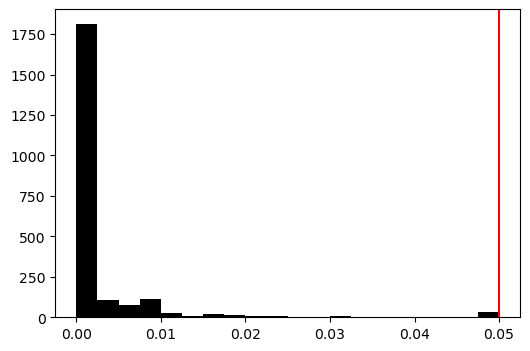

In [41]:
# set significant criteria of p
# 看 p 的分布
p_thres = 0.05
print(gene_total_score_data['p'].describe())
plt.figure(figsize = (6, 4))
plt.hist(list(gene_total_score_data['p']), bins = 20, color = 'black')
plt.axvline(x = p_thres, color = 'red')
plt.show()

In [42]:
print('significant number based on current threshold:', len(gene_total_score_data[(gene_total_score_data['p'] < p_thres)]))
print('total gene data:', len(gene_total_score_data[(gene_total_score_data['p_flag'] == '1')]))
print(len(gene_total_score_data[(gene_total_score_data['p'] < p_thres)]) / len(gene_total_score_data[(gene_total_score_data['p_flag'] == '1')]))

significant number based on current threshold: 2206
total gene data: 2232
0.9883512544802867


In [43]:
# siginicant_flag: 1 is significant and 0 is non-sig
# set threshold
p_thres = 0.05
lod_thres = 2

gene_total_score_data['sig_flag'] = ''
gene_total_score_data['nonsig_flag'] = ''
gene_total_score_data.loc[(gene_total_score_data['p'] < p_thres), 'sig_flag'] = 1
gene_total_score_data.loc[(gene_total_score_data['p'] < p_thres), 'nonsig_flag'] = 0

gene_total_score_data.loc[(gene_total_score_data['p'] >= p_thres), 'nonsig_flag'] = 1
gene_total_score_data.loc[(gene_total_score_data['p'] >= p_thres), 'sig_flag'] = 0

gene_total_score_data.loc[(gene_total_score_data['lod'] > lod_thres), 'sig_flag'] = 1
gene_total_score_data.loc[(gene_total_score_data['lod'] > lod_thres), 'nonsig_flag'] = 0

gene_total_score_data.loc[(gene_total_score_data['lod'] <= lod_thres), 'nonsig_flag'] = 1
gene_total_score_data.loc[(gene_total_score_data['lod'] <= lod_thres), 'sig_flag'] = 0

In [44]:
gene_total_score_data.head()

,gene,p,lod,gene_version,article_name,gene_org,p_flag,lod_flag,sig_flag,nonsig_flag
0,Glyma.01g037600,0.000007,NaN,2.0,Genome-Wide Association Analyses Reveal Genomi...,Glyma.01g037600,1,,1,0
1,Glyma.01g037700,0.000007,NaN,2.0,Genome-Wide Association Analyses Reveal Genomi...,Glyma.01g037700,1,,1,0
2,Glyma.01g037800,0.000007,NaN,2.0,Genome-Wide Association Analyses Reveal Genomi...,Glyma.01g037800,1,,1,0
3,Glyma.01g037900,0.000007,NaN,2.0,Genome-Wide Association Analyses Reveal Genomi...,Glyma.01g037900,1,,1,0
4,Glyma.01g038000,0.000007,NaN,2.0,Genome-Wide Association Analyses Reveal Genomi...,Glyma.01g038000,1,,1,0


In [46]:
# gene_list = list(gene_total_score_data['gene'].unique())
# gene_total_score_data_v1 = pd.DataFrame()
# count = 0

# for gene in gene_list:
#     df_gene = gene_total_score_data[gene_total_score_data['gene'] == gene].reset_index().drop(['index'], axis = 1)
#     # 除單個錯誤(可能是資料重複蒐集)
#     if gene == 'Glyma.20g003400':
#         df_gene = df_gene.drop_duplicates(['article_name', 'p'])
    
#     # 進入significance flagging
#     df_gene['sig_flag_fv'] = ''
#     if df_gene['sig_flag'].sum() > df_gene['nonsig_flag'].sum():
#         df_gene['sig_flag_fv'] = '1'
        
#     elif df_gene['sig_flag'].sum() == df_gene['nonsig_flag'].sum():
#         df_gene['sig_flag_fv'] = '0'
    
#     else:
#         df_gene['sig_flag_fv'] = '-1'
    
#     gene_total_score_data_v1 = pd.concat([gene_total_score_data_v1, df_gene[['gene', 'p', 'lod', 'gene_version', 'article_name', 'gene_org', 'p_flag', 'lod_flag', 'sig_flag_fv']]]).reset_index().drop(['index'], axis = 1)
#     count += 1
    
#     if count % 300 == 0:
#         print(count)

300
600
900
1200
1500
1800
2100
2400
2700
3000


In [45]:
# 整合p值
gene_list = list(gene_total_score_data['gene'].unique())
gene_total_score_data_v2 = pd.DataFrame()

count = 0
for gene in gene_list:
    df_gene = gene_total_score_data[gene_total_score_data['gene'] == gene].reset_index().drop(['index'], axis = 1)
    p_list = list(df_gene[df_gene['p'].isna() == False]['p'])
    lod_list = list(df_gene[df_gene['lod'].isna() == False]['lod'])
    if len(p_list) > 0:
        p_value_p = stats.combine_pvalues(p_list, method = 'fisher')[1]
        
        if len(lod_list) == 1:  # 當有p值且lod值只有一個
            lod_value_p = 10 ** -(lod_list[0] * np.log(2))
            final_p_list = [p_value_p, lod_value_p]
            final_p = stats.combine_pvalues(final_p_list, method = 'fisher')[1]

        elif len(lod_list) > 1: # 當有p值且lod值有大於一個
            lod_list_p_v1 = 10 ** -(np.array(lod_list) * np.log(2))
            lod_value_p = stats.combine_pvalues(lod_list_p_v1, method = 'fisher')[1]
            final_p_list = [p_value_p, lod_value_p]
            final_p = stats.combine_pvalues(final_p_list, method = 'fisher')[1]
    
        else:
            final_p = p_value_p
            
    elif len(p_list) == 0:
        if len(lod_list) == 1:   # 當沒有p值且 lod 值只有一個
            lod_value_p = 10 ** -(lod_list[0] * np.log(2))
            final_p = lod_value_p
        
        elif len(lod_list) > 1:  # 當沒有p值且 lod 值大於一個
            lod_list_p_v1 = 10 ** -(np.array(lod_list) * np.log(2))
            lod_value_p = stats.combine_pvalues(lod_list_p_v1, method = 'fisher')[1]
            final_p = stats.combine_pvalues(final_p_list, method = 'fisher')[1]
            
        else:
            final_p = np.nan
    
    df_gene_v1 = pd.DataFrame()
    df_gene_v1['gene'] = df_gene['gene'].unique()
    df_gene_v1['p_processed'] = final_p
    df_gene_v1['sig_flag'] = df_gene['sig_flag'].sum()
    df_gene_v1['nonsig_flag'] = df_gene['nonsig_flag'].sum()
    
    gene_total_score_data_v2 = pd.concat([gene_total_score_data_v2, df_gene_v1]).reset_index().drop(['index'], axis = 1)
    
    count += 1
    if count % 300 == 0:
        print(count)

300
600
900
1200
1500
1800
2100
2400
2700
3000


In [46]:
# 已轉出各基因的p
gene_total_score_data_v2.head()

,gene,p_processed,sig_flag,nonsig_flag
0,Glyma.01g037600,0.000007,1,0
1,Glyma.01g037700,0.000007,1,0
2,Glyma.01g037800,0.000007,1,0
3,Glyma.01g037900,0.000007,1,0
4,Glyma.01g038000,0.000007,1,0


In [47]:
# 以 log10 為底轉換成 scoring
gene_total_score_data_v2['score'] = -np.log10(gene_total_score_data_v2['p_processed'])

(array([1.661e+03, 9.100e+02, 3.130e+02, 9.600e+01, 5.900e+01, 5.500e+01,
        1.000e+00, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([ 1.30103   ,  4.18360498,  7.06617997,  9.94875495, 12.83132994,
        15.71390493, 18.59647991, 21.4790549 , 24.36162988, 27.24420487,
        30.12677986]),
 <BarContainer object of 10 artists>)

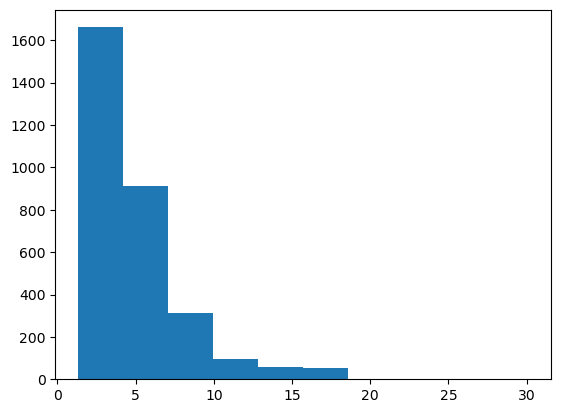

In [48]:
plt.hist(gene_total_score_data_v2['score'])

In [48]:
len(gene_total_score_data_v2['score'])

3098

# L1: 15 < x <= max in [5, 6] #about 77
# L2: 8 < x <= 15 in [4, 5] #about 338
# L3: 5 < x <= 8 in [3, 4] #about 736
# L4: 2.8 < x <= 5 in [2, 3] #about 841
# L5: 0 < x <= 2.8 in [0, 2] #about 1106

In [49]:
# data scaling function
def scale_score(x, upper_b, lower_b, max_val, min_val):
    scaling = (upper_b - lower_b) / (max_val - min_val)
    return (x - min_val) * scaling + lower_b

In [50]:
# L1 coping 15 < x < max
upper_b = 6
lower_b = 5
max_val = gene_total_score_data_v2['score'].max()
min_val = 15
gene_total_score_data_v2_L1 = gene_total_score_data_v2[(gene_total_score_data_v2['score'] > min_val) & (gene_total_score_data_v2['score'] <= max_val)].reset_index().drop(['index'], axis = 1)

gene_total_score_data_v2_L1['score_new'] = gene_total_score_data_v2_L1['score'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [51]:
# L2 coping 8 < x < 15
upper_b = 5
lower_b = 4
max_val = 15
min_val = 8
gene_total_score_data_v2_L2 = gene_total_score_data_v2[(gene_total_score_data_v2['score'] > min_val) & (gene_total_score_data_v2['score'] <= max_val)].reset_index().drop(['index'], axis = 1)

gene_total_score_data_v2_L2['score_new'] = gene_total_score_data_v2_L2['score'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [52]:
# L3 coping 5 < x < 8
upper_b = 4
lower_b = 3
max_val = 8
min_val = 5
gene_total_score_data_v2_L3 = gene_total_score_data_v2[(gene_total_score_data_v2['score'] > min_val) & (gene_total_score_data_v2['score'] <= max_val)].reset_index().drop(['index'], axis = 1)

gene_total_score_data_v2_L3['score_new'] = gene_total_score_data_v2_L3['score'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [53]:
# L4 coping 2.8 < x < 5
upper_b = 3
lower_b = 2
max_val = 5
min_val = 2.8
gene_total_score_data_v2_L4 = gene_total_score_data_v2[(gene_total_score_data_v2['score'] > min_val) & (gene_total_score_data_v2['score'] <= max_val)].reset_index().drop(['index'], axis = 1)

gene_total_score_data_v2_L4['score_new'] = gene_total_score_data_v2_L4['score'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [54]:
# L5 coping 0 < x < 2.8
upper_b = 2
lower_b = 0
max_val = 2.8
min_val = 0
gene_total_score_data_v2_L5 = gene_total_score_data_v2[(gene_total_score_data_v2['score'] > min_val) & (gene_total_score_data_v2['score'] <= max_val)].reset_index().drop(['index'], axis = 1)

gene_total_score_data_v2_L5['score_new'] = gene_total_score_data_v2_L5['score'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [55]:
gene_total_score_data_v3 = pd.concat([gene_total_score_data_v2_L1, gene_total_score_data_v2_L2, gene_total_score_data_v2_L3, gene_total_score_data_v2_L4, gene_total_score_data_v2_L5]).reset_index().drop(['index'], axis = 1)

(array([ 77., 552., 332., 488., 211., 267., 355., 253., 142., 225.,  78.,
         41.,  73.,   3.,   1.]),
 array([0.92930714, 1.26735333, 1.60539952, 1.94344571, 2.2814919 ,
        2.61953809, 2.95758428, 3.29563047, 3.63367667, 3.97172286,
        4.30976905, 4.64781524, 4.98586143, 5.32390762, 5.66195381,
        6.        ]),
 <BarContainer object of 15 artists>)

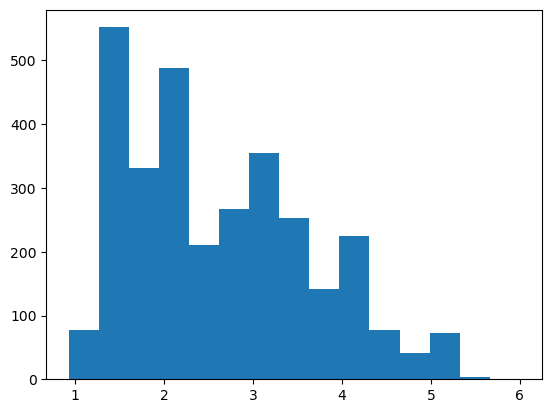

In [56]:
plt.hist(gene_total_score_data_v3['score_new'], bins = 15)

In [57]:
gene_total_score_data_v3 = gene_total_score_data_v3.rename(columns = {'score':'score_raw', 'score_new':'score_individual', 'sig_flag':'sig_flag_individual', 'nonsig_flag':'nonsig_flag_individual'})

In [58]:
gene_total_score_data_v3.head()

,gene,p_processed,sig_flag_individual,nonsig_flag_individual,score_raw,score_individual
0,Glyma.10g192200,1.000000e-16,1,0,16.0,5.066108
1,Glyma.10g192300,1.000000e-16,1,0,16.0,5.066108
2,Glyma.10g192400,1.000000e-16,1,0,16.0,5.066108
3,Glyma.10g192500,1.000000e-16,1,0,16.0,5.066108
4,Glyma.10g192600,1.000000e-16,1,0,16.0,5.066108


In [206]:
saleem2022 = pd.read_excel(r'C:\Users\edwar\Desktop\農藝\paper2\data collection\whole genome data\complete\GWAS\Saleem-2022\GWAS whole genome data_v2.xlsx')

--- new approach ---

In [207]:
saleem2022.loc[(saleem2022['P.value_CW_SDS'] == 0), 'P.value_CW_SDS'] = 10 ** -8
saleem2022.loc[(saleem2022['P.value_CW_LDS'] == 0), 'P.value_CW_LDS'] = 10 ** -8
saleem2022.loc[(saleem2022['P.value_LSEN_SDS'] == 0), 'P.value_LSEN_SDS'] = 10 ** -8
saleem2022.loc[(saleem2022['P.value_LSEN_LDS'] == 0), 'P.value_LSEN_LDS'] = 10 ** -8
saleem2022.loc[(saleem2022['P.value_AGRmax-Yr_SDS'] == 0), 'P.value_AGRmax-Yr_SDS'] = 10 ** -8
saleem2022.loc[(saleem2022['P.value_AGRmax-Yr_LDS'] == 0), 'P.value_AGRmax-Yr_LDS'] = 10 ** -8
saleem2022.loc[(saleem2022['P.value_CH-Yr_SDS'] == 0), 'P.value_CH-Yr_SDS'] = 10 ** -8
saleem2022.loc[(saleem2022['P.value_CH-Yr_LDS'] == 0), 'P.value_CH-Yr_LDS'] = 10 ** -8

In [208]:
gene_list = list(saleem2022['gene'].unique())
saleem2022_v1 = pd.DataFrame()
count = 0

for gene in gene_list:
    df_gene_v1 = pd.DataFrame()
    df_gene = saleem2022[saleem2022['gene'] == gene].reset_index().drop(['index'], axis = 1)
    df_gene_SD = df_gene[['gene', 'P.value_CW_SDS', 'P.value_LSEN_SDS', 'P.value_AGRmax-Yr_SDS', 'P.value_CH-Yr_SDS']]
    df_gene_LD = df_gene[['gene', 'P.value_CW_LDS', 'P.value_LSEN_LDS', 'P.value_AGRmax-Yr_LDS', 'P.value_CH-Yr_LDS']]
    p_values_SD = np.array([df_gene_SD['P.value_CW_SDS'].min(), df_gene_SD['P.value_LSEN_SDS'].min(), df_gene_SD['P.value_AGRmax-Yr_SDS'].min(), df_gene_SD['P.value_CH-Yr_SDS'].min()])
    p_values_LD = np.array([df_gene_LD['P.value_CW_LDS'].min(), df_gene_LD['P.value_LSEN_LDS'].min(), df_gene_LD['P.value_AGRmax-Yr_LDS'].min(), df_gene_LD['P.value_CH-Yr_LDS'].min()])
    # p_values_SD_v1 = p_values_SD[p_values_SD <= 0.3]
    # p_values_LD_v1 = p_values_LD[p_values_LD <= 0.3]
    p_values_SD_v1 = p_values_SD[p_values_SD <= 0.1]
    p_values_LD_v1 = p_values_LD[p_values_LD <= 0.1]
    
    # --- coping short-term
    if len(p_values_SD_v1) == 1:
        p_value_SD = p_values_SD_v1[0]

    elif len(p_values_SD_v1) == 0:
        # p_value_SD = p_values_SD.min() 改用 combine p
        p_value_SD = stats.combine_pvalues(list(p_values_SD), method = 'fisher')[1]

    else:
        p_value_SD = stats.combine_pvalues(p_values_SD_v1, method = 'fisher')[1]

    # --- coping long-term
    if len(p_values_LD_v1) == 1:
        p_value_LD = p_values_LD_v1[0]

    elif len(p_values_LD_v1) == 0:
        # p_value_LD = p_values_LD.min()
        p_value_LD = stats.combine_pvalues(list(p_values_LD), method = 'fisher')[1]

    else:
        p_value_LD = stats.combine_pvalues(p_values_LD_v1, method = 'fisher')[1]
        
    df_gene_v1['gene'] = df_gene['gene'].unique()
    df_gene_v1['p_SD'] = p_value_SD
    df_gene_v1['p_LD'] = p_value_LD
    df_gene_v1['p_val'] = stats.combine_pvalues([p_value_SD, p_value_LD], method = 'fisher')[1]
    saleem2022_v1 = pd.concat([saleem2022_v1, df_gene_v1]).reset_index().drop(['index'], axis = 1)
    
    count += 1
    if count % 5000 == 0:
        print(count)
    
saleem2022_v1['sig_flag'] = ''
saleem2022_v1['nonsig_flag'] = ''
saleem2022_v1.loc[(saleem2022_v1['p_SD'] > 0.05), 'sig_flag'] = 0
saleem2022_v1.loc[(saleem2022_v1['p_LD'] > 0.05), 'sig_flag'] = 0
saleem2022_v1.loc[(saleem2022_v1['p_SD'] < 0.05), 'sig_flag'] = 1
saleem2022_v1.loc[(saleem2022_v1['p_LD'] < 0.05), 'sig_flag'] = 1
saleem2022_v1.loc[((saleem2022_v1['p_LD'] < 0.05) & (saleem2022_v1['p_SD'] < 0.05)), 'sig_flag'] = 2
saleem2022_v1.loc[(saleem2022_v1['p_SD'] < 0.05), 'nonsig_flag'] = 0
saleem2022_v1.loc[(saleem2022_v1['p_LD'] < 0.05), 'nonsig_flag'] = 0
saleem2022_v1.loc[(saleem2022_v1['p_SD'] > 0.05), 'nonsig_flag'] = 1
saleem2022_v1.loc[(saleem2022_v1['p_LD'] > 0.05), 'nonsig_flag'] = 1
saleem2022_v1.loc[((saleem2022_v1['p_LD'] > 0.05) & (saleem2022_v1['p_SD'] > 0.05)), 'nonsig_flag'] = 2

5000
10000
15000
20000
25000
30000
35000
40000
45000


In [213]:
# saleem2022_v1.to_excel(r'C:\Users\edwar\Desktop\農藝\paper2\data collection\saleem2022_integration_v1.xlsx', index = False)

In [210]:
saleem2022_v1['score_raw'] = -np.log10(saleem2022_v1['p_val'])

(array([1.1641e+04, 2.1789e+04, 1.1305e+04, 2.6120e+03, 1.6860e+03,
        5.1400e+02, 6.0000e+01, 5.2000e+01, 0.0000e+00, 3.0000e+00]),
 array([1.36614136e-05, 2.33879291e+00, 4.67757216e+00, 7.01635140e+00,
        9.35513065e+00, 1.16939099e+01, 1.40326891e+01, 1.63714684e+01,
        1.87102476e+01, 2.10490269e+01, 2.33878061e+01]),
 <BarContainer object of 10 artists>)

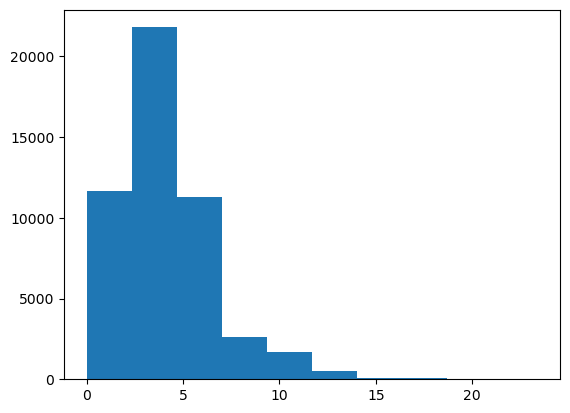

In [211]:
plt.hist(saleem2022_v1['score_raw'])

In [212]:
saleem2022_v1['score_raw'].describe()

count    49662.000000
mean         4.089709
std          2.436296
min          0.000014
25%          2.438893
50%          3.710426
75%          5.198221
max         23.387806
Name: score_raw, dtype: float64

In [215]:
len(saleem2022_v1[saleem2022_v1['score_raw'] > 13])

209

In [220]:
cri1 = saleem2022_v1['score_raw'] <= 2
cri2 = saleem2022_v1['score_raw'] > 0
len(saleem2022_v1[cri1 & cri2])

8867

# L1: 13 < x <= max in [5, 6] #209
# L2: 9 < x <= 13 in [4, 5] #2380
# L3: 6 < x <= 9 in [3, 4] #5551
# L4: 4 < x <= 6 in [2, 3] #13922
# L5: 2 < x <= 4 in [1, 2] #18773
# L6: 0 < x <= 2 in [0, 1] #8867

In [221]:
# L1 scaling
upper_b = 6
lower_b = 5
max_val = saleem2022_v1['score_raw'].max()
min_val = 13

saleem2022_v1_L1 = saleem2022_v1[(saleem2022_v1['score_raw'] > min_val) & (saleem2022_v1['score_raw'] <= max_val)].reset_index().drop(['index'], axis = 1)
saleem2022_v1_L1['score_saleem2022'] = saleem2022_v1_L1['score_raw'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [222]:
# L2 scaling
upper_b = 5
lower_b = 4
max_val = 13
min_val = 9

saleem2022_v1_L2 = saleem2022_v1[(saleem2022_v1['score_raw'] > min_val) & (saleem2022_v1['score_raw'] <= max_val)].reset_index().drop(['index'], axis = 1)
saleem2022_v1_L2['score_saleem2022'] = saleem2022_v1_L2['score_raw'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [223]:
# L3 scaling
upper_b = 4
lower_b = 3
max_val = 9
min_val = 6

saleem2022_v1_L3 = saleem2022_v1[(saleem2022_v1['score_raw'] > min_val) & (saleem2022_v1['score_raw'] <= max_val)].reset_index().drop(['index'], axis = 1)
saleem2022_v1_L3['score_saleem2022'] = saleem2022_v1_L3['score_raw'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [224]:
# L4 scaling
upper_b = 3
lower_b = 2
max_val = 6
min_val = 4

saleem2022_v1_L4 = saleem2022_v1[(saleem2022_v1['score_raw'] > min_val) & (saleem2022_v1['score_raw'] <= max_val)].reset_index().drop(['index'], axis = 1)
saleem2022_v1_L4['score_saleem2022'] = saleem2022_v1_L4['score_raw'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [225]:
# L5 scaling
upper_b = 2
lower_b = 1
max_val = 4
min_val = 2

saleem2022_v1_L5 = saleem2022_v1[(saleem2022_v1['score_raw'] > min_val) & (saleem2022_v1['score_raw'] <= max_val)].reset_index().drop(['index'], axis = 1)
saleem2022_v1_L5['score_saleem2022'] = saleem2022_v1_L5['score_raw'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [226]:
# L6 scaling
upper_b = 1
lower_b = 0
max_val = 2
min_val = 0

saleem2022_v1_L6 = saleem2022_v1[(saleem2022_v1['score_raw'] > min_val) & (saleem2022_v1['score_raw'] <= max_val)].reset_index().drop(['index'], axis = 1)
saleem2022_v1_L6['score_saleem2022'] = saleem2022_v1_L6['score_raw'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [227]:
saleem2022_v1 = pd.concat([saleem2022_v1_L1, saleem2022_v1_L2, saleem2022_v1_L3, saleem2022_v1_L4, saleem2022_v1_L5, saleem2022_v1_L6]).reset_index().drop(['index'], axis = 1)

(array([ 3740.,  8371., 11685., 10663.,  7063.,  4438.,  1812.,  1488.,
          373.,    29.]),
 array([6.83070681e-06, 6.00006148e-01, 1.20000546e+00, 1.80000478e+00,
        2.40000410e+00, 3.00000342e+00, 3.60000273e+00, 4.20000205e+00,
        4.80000137e+00, 5.40000068e+00, 6.00000000e+00]),
 <BarContainer object of 10 artists>)

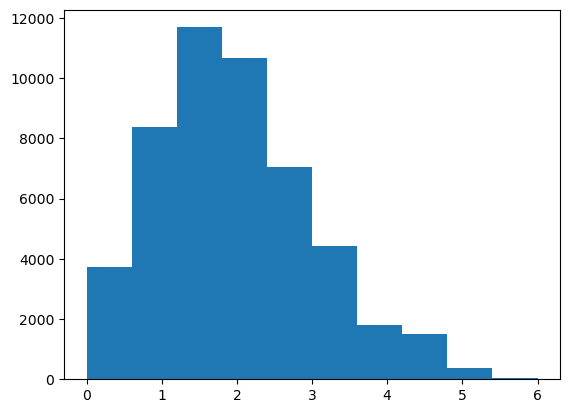

In [228]:
plt.hist(saleem2022_v1['score_saleem2022'])

In [229]:
saleem2022_v2 = saleem2022_v1.copy()
saleem2022_v2 = saleem2022_v2.rename(columns = {'sig_flag':'sig_flag_saleem2022', 'nonsig_flag':'nonsig_flag_saleem2022'})[['gene', 'sig_flag_saleem2022', 'nonsig_flag_saleem2022', 'score_saleem2022']]

In [230]:
gene_total_score_data_v3 = gene_total_score_data_v3.rename(columns = {'sig_flag':'sig_flag_individual', 'nonsig_flag':'nonsig_flag_individual', 'score_new':'score_individual'})
gene_score_total = gene_total_score_data_v3[['gene', 'sig_flag_individual', 'nonsig_flag_individual', 'score_individual']].merge(saleem2022_v2[['gene', 'sig_flag_saleem2022', 'nonsig_flag_saleem2022', 'score_saleem2022']], how = 'outer', on = ['gene'])
gene_score_total['score_total'] = gene_score_total[['score_individual', 'score_saleem2022']].sum(axis = 1)
gene_score_total['sigflag_total'] = gene_score_total[['sig_flag_individual', 'sig_flag_saleem2022']].sum(axis = 1)
gene_score_total['nonsigflag_total'] = gene_score_total[['nonsig_flag_individual', 'nonsig_flag_saleem2022']].sum(axis = 1)

In [231]:
gene_score_total.score_total.describe()

count    49836.000000
mean         2.129941
std          1.254079
min          0.000007
25%          1.254100
50%          1.925446
75%          2.757962
max          9.780306
Name: score_total, dtype: float64

(array([ 8127., 17309., 13604.,  6199.,  3020.,   917.,   409.,   162.,
           64.,    25.]),
 array([6.83070681e-06, 9.78036787e-01, 1.95606674e+00, 2.93409670e+00,
        3.91212665e+00, 4.89015661e+00, 5.86818657e+00, 6.84621652e+00,
        7.82424648e+00, 8.80227643e+00, 9.78030639e+00]),
 <BarContainer object of 10 artists>)

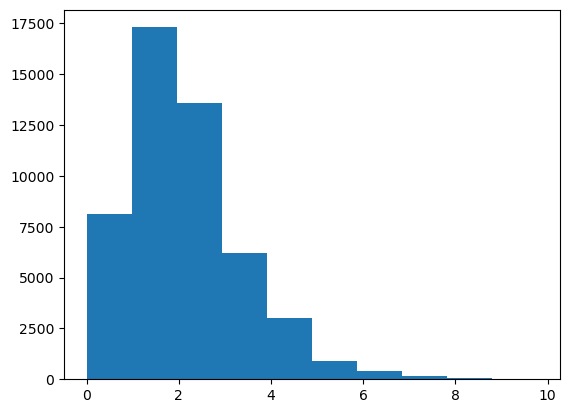

In [233]:
plt.hist(gene_score_total['score_total'])

In [234]:
len(gene_score_total[gene_score_total['score_total'] > 7])

217

In [238]:
cri1 = gene_score_total['score_total'] <= 2
cri2 = gene_score_total['score_total'] > 0
len(gene_score_total[cri1 & cri2])

26241

# L1: 7 < x <= max in [5, 6] #217
# L2: 4.3 < x <= 7 in [4, 5] #2994
# L3: 3 < x <= 4.3 in [3, 4] #7008
# L4: 2 < x <= 3 in [2, 3] #13376
# L5: 0 < x <= 2 in [0, 2]

In [239]:
# L1 scaling
upper_b = 6
lower_b = 5
max_val = gene_score_total['score_total'].max()
min_val = 7

gene_score_total_L1 = gene_score_total[(gene_score_total['score_total'] > min_val) & (gene_score_total['score_total'] <= max_val)].reset_index().drop(['index'], axis = 1)
gene_score_total_L1['score'] = gene_score_total_L1['score_total'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [240]:
# L2 scaling
upper_b = 5
lower_b = 4
max_val = 7
min_val = 4.3

gene_score_total_L2 = gene_score_total[(gene_score_total['score_total'] > min_val) & (gene_score_total['score_total'] <= max_val)].reset_index().drop(['index'], axis = 1)
gene_score_total_L2['score'] = gene_score_total_L2['score_total'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [241]:
# L3 scaling
upper_b = 4
lower_b = 3
max_val = 4.3
min_val = 3

gene_score_total_L3 = gene_score_total[(gene_score_total['score_total'] > min_val) & (gene_score_total['score_total'] <= max_val)].reset_index().drop(['index'], axis = 1)
gene_score_total_L3['score'] = gene_score_total_L3['score_total'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [242]:
# L4 scaling
upper_b = 3
lower_b = 0
max_val = 3
min_val = 0

gene_score_total_L4 = gene_score_total[(gene_score_total['score_total'] > min_val) & (gene_score_total['score_total'] <= max_val)].reset_index().drop(['index'], axis = 1)
gene_score_total_L4['score'] = gene_score_total_L4['score_total'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [243]:
gene_score_total = pd.concat([gene_score_total_L1, gene_score_total_L2, gene_score_total_L3, gene_score_total_L4]).reset_index().drop(['index'], axis = 1)

(array([ 3573.,  7975., 11066., 10193.,  6810.,  5176.,  3391.,  1289.,
          302.,    61.]),
 array([6.83070681e-06, 6.00006148e-01, 1.20000546e+00, 1.80000478e+00,
        2.40000410e+00, 3.00000342e+00, 3.60000273e+00, 4.20000205e+00,
        4.80000137e+00, 5.40000068e+00, 6.00000000e+00]),
 <BarContainer object of 10 artists>)

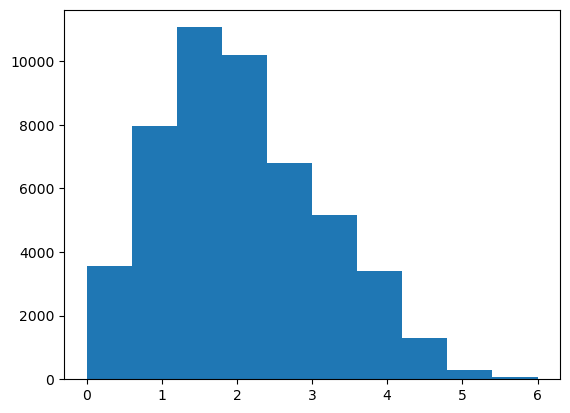

In [244]:
plt.hist(gene_score_total['score'])

In [245]:
gene_score_total.to_excel(r'C:\Users\edwar\Desktop\農藝\paper2\data collection\dna_layer_final_new_v1.xlsx', index = False)

--- new approach --- up

In [82]:
df_gene = saleem2022[saleem2022['gene'] == 'Glyma.01g000100'].reset_index().drop(['index'], axis = 1)
df_gene = df_gene.drop_duplicates(['P.value_CW_SDS', 'P.value_CW_LDS', 'P.value_LSEN_SDS', 'P.value_LSEN_LDS', 'P.value_AGRmax-Yr_SDS', 'P.value_AGRmax-Yr_LDS', 'P.value_CH-Yr_SDS', 'P.value_CH-Yr_LDS']).reset_index().drop(['index'], axis = 1)
df_gene_SD = df_gene[['gene', 'P.value_CW_SDS', 'P.value_LSEN_SDS', 'P.value_AGRmax-Yr_SDS', 'P.value_CH-Yr_SDS']]
df_gene_LD = df_gene[['gene', 'P.value_CW_LDS', 'P.value_LSEN_LDS', 'P.value_AGRmax-Yr_LDS', 'P.value_CH-Yr_LDS']]
p_values_SD = [stats.combine_pvalues(df_gene_SD['P.value_CW_SDS'])[1], stats.combine_pvalues(df_gene_SD['P.value_LSEN_SDS'])[1], stats.combine_pvalues(df_gene_SD['P.value_AGRmax-Yr_SDS'])[1], stats.combine_pvalues(df_gene_SD['P.value_CH-Yr_SDS'])[1]]
p_values_LD = [stats.combine_pvalues(df_gene_LD['P.value_CW_LDS'])[1], stats.combine_pvalues(df_gene_LD['P.value_LSEN_LDS'])[1], stats.combine_pvalues(df_gene_LD['P.value_AGRmax-Yr_LDS'])[1], stats.combine_pvalues(df_gene_LD['P.value_CH-Yr_LDS'])[1]]
print(p_values_SD, '\t', p_values_LD)

[0.9956960429844884, 0.21480514562846836, 0.9988220056958469, 0.059481307517510996] 	 [0.06690396913630547, 0.07176483375444845, 0.318262247839965, 0.8779635676225199]


In [136]:
gene_list = list(saleem2022['gene'].unique())
saleem2022_v1 = pd.DataFrame()

count = 0
for gene in gene_list:
    df_gene_v1 = pd.DataFrame()
    df_gene = saleem2022[saleem2022['gene'] == gene].reset_index().drop(['index'], axis = 1)
    df_gene = df_gene.drop_duplicates(['P.value_CW_SDS', 'P.value_CW_LDS', 'P.value_LSEN_SDS', 'P.value_LSEN_LDS', 'P.value_AGRmax-Yr_SDS', 'P.value_AGRmax-Yr_LDS', 'P.value_CH-Yr_SDS', 'P.value_CH-Yr_LDS']).reset_index().drop(['index'], axis = 1)
    df_gene_SD = df_gene[['gene', 'P.value_CW_SDS', 'P.value_LSEN_SDS', 'P.value_AGRmax-Yr_SDS', 'P.value_CH-Yr_SDS']]
    df_gene_LD = df_gene[['gene', 'P.value_CW_LDS', 'P.value_LSEN_LDS', 'P.value_AGRmax-Yr_LDS', 'P.value_CH-Yr_LDS']]
    p_values_SD = [stats.combine_pvalues(df_gene_SD['P.value_CW_SDS'], method = 'fisher')[1], stats.combine_pvalues(df_gene_SD['P.value_LSEN_SDS'], method = 'fisher')[1], stats.combine_pvalues(df_gene_SD['P.value_AGRmax-Yr_SDS'], method = 'fisher')[1], stats.combine_pvalues(df_gene_SD['P.value_CH-Yr_SDS'], method = 'fisher')[1]]
    p_values_LD = [stats.combine_pvalues(df_gene_LD['P.value_CW_LDS'], method = 'fisher')[1], stats.combine_pvalues(df_gene_LD['P.value_LSEN_LDS'], method = 'fisher')[1], stats.combine_pvalues(df_gene_LD['P.value_AGRmax-Yr_LDS'], method = 'fisher')[1], stats.combine_pvalues(df_gene_LD['P.value_CH-Yr_LDS'], method = 'fisher')[1]]
    p_value_SD = stats.combine_pvalues(p_values_SD, method = 'fisher')[1]
    p_value_LD = stats.combine_pvalues(p_values_LD, method = 'fisher')[1]
    df_gene_v1['gene'] = df_gene['gene'].unique()
    df_gene_v1['p_SD'] = p_value_SD
    df_gene_v1['p_LD'] = p_value_LD
    df_gene_v1['p_val'] = stats.combine_pvalues([p_value_SD, p_value_LD], method = 'fisher')[1]
    saleem2022_v1 = pd.concat([saleem2022_v1, df_gene_v1]).reset_index().drop(['index'], axis = 1)
    
    count += 1
    if count % 5000 == 0:
        print(count)
        
saleem2022_v1['sig_flag'] = ''
saleem2022_v1['nonsig_flag'] = ''
saleem2022_v1.loc[(saleem2022_v1['p_SD'] > 0.05), 'sig_flag'] = 0
saleem2022_v1.loc[(saleem2022_v1['p_LD'] > 0.05), 'sig_flag'] = 0
saleem2022_v1.loc[(saleem2022_v1['p_SD'] < 0.05), 'sig_flag'] = 1
saleem2022_v1.loc[(saleem2022_v1['p_LD'] < 0.05), 'sig_flag'] = 1
saleem2022_v1.loc[((saleem2022_v1['p_LD'] < 0.05) & (saleem2022_v1['p_SD'] < 0.05)), 'sig_flag'] = 2
saleem2022_v1.loc[(saleem2022_v1['p_SD'] < 0.05), 'nonsig_flag'] = 0
saleem2022_v1.loc[(saleem2022_v1['p_LD'] < 0.05), 'nonsig_flag'] = 0
saleem2022_v1.loc[(saleem2022_v1['p_SD'] > 0.05), 'nonsig_flag'] = 1
saleem2022_v1.loc[(saleem2022_v1['p_LD'] > 0.05), 'nonsig_flag'] = 1
saleem2022_v1.loc[((saleem2022_v1['p_LD'] > 0.05) & (saleem2022_v1['p_SD'] > 0.05)), 'nonsig_flag'] = 2

C:\Users\edwar\Anaconda3\lib\site-packages\scipy\stats\stats.py:8203: RuntimeWarning: divide by zero encountered in log
  statistic = -2 * np.sum(np.log(pvalues))
C:\Users\edwar\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2039: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


5000
10000
15000
20000
25000
30000
35000
40000
45000


In [168]:
saleem2022_v2 = saleem2022_v1.copy()
saleem2022_v2.loc[(saleem2022_v2['p_SD'] == 0), 'p_SD'] = 10 ** -32
saleem2022_v2.loc[(saleem2022_v2['p_LD'] == 0), 'p_LD'] = 10 ** -32
saleem2022_v3 = pd.DataFrame()

gene_list = list(saleem2022_v2['gene'].unique())
count = 0
for gene in gene_list:
    df_gene = saleem2022_v2[saleem2022_v2['gene'] == gene].reset_index().drop(['index'], axis = 1)
    df_gene_v1 = pd.DataFrame()
    df_gene_v1['gene'] = df_gene['gene']
    df_gene_v1['p_val'] = stats.combine_pvalues([float(df_gene['p_SD']), float(df_gene['p_LD'])], method = 'fisher')[1]
    df_gene_v1['sig_flag'] = df_gene['sig_flag']
    df_gene_v1['nonsig_flag'] = df_gene['nonsig_flag']
    saleem2022_v3 = pd.concat([saleem2022_v3, df_gene_v1]).reset_index().drop(['index'], axis = 1)
    
    count += 1
    if count % 5000 == 0:
        print(count)

5000
10000
15000
20000
25000
30000
35000
40000
45000


In [170]:
saleem2022_v3['score_raw'] = -np.log10(saleem2022_v3['p_val'])

In [172]:
saleem2022_v3['score_raw'].describe()

count    49662.000000
mean         6.270079
std          8.437409
min          0.000021
25%          1.551709
50%          3.471908
75%          6.868108
max         61.828667
Name: score_raw, dtype: float64

(array([3.5439e+04, 8.8930e+03, 1.6390e+03, 2.7200e+02, 6.0800e+02,
        2.3330e+03, 3.7300e+02, 5.0000e+01, 4.0000e+00, 5.1000e+01]),
 array([2.08311948e-05, 6.18288547e+00, 1.23657501e+01, 1.85486148e+01,
        2.47314794e+01, 3.09143440e+01, 3.70972087e+01, 4.32800733e+01,
        4.94629380e+01, 5.56458026e+01, 6.18286672e+01]),
 <a list of 10 Patch objects>)

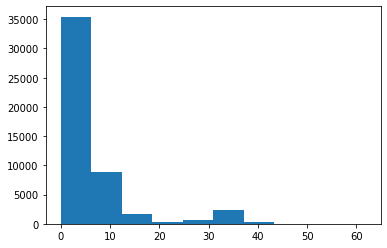

In [171]:
plt.hist(saleem2022_v3['score_raw'])

# L1: 41 < x <= max in [5, 6] #about 166
# L2: 35 < x <= 41 [4, 5] #about 764
# L3: 20 < x <= 35 in [3, 4] #about 2646
# L4: 8 < x <= 20 in [2, 3] #about 6528
# L5: 3 < x < 8 in [1, 2] #about 17319
# L6: 0 < x < 3 in [0, 1] #about 22239

In [198]:
def scale_score(x, upper_b, lower_b, max_val, min_val):
    scaling = (upper_b - lower_b) / (max_val - min_val)
    return (x - min_val) * scaling + lower_b

In [200]:
# L1 rescaling
upper_b = 6
lower_b = 5
max_val = saleem2022_v3['score_raw'].max()
min_val = 41
saleem2022_v3_L1 = saleem2022_v3[(saleem2022_v3['score_raw'] > min_val) & (saleem2022_v3['score_raw'] <= max_val)].reset_index().drop(['index'], axis = 1)

saleem2022_v3_L1['score_saleem2022'] = saleem2022_v3_L1['score_raw'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [201]:
# L2 rescaling
upper_b = 5
lower_b = 4
max_val = 41
min_val = 35
saleem2022_v3_L2 = saleem2022_v3[(saleem2022_v3['score_raw'] > min_val) & (saleem2022_v3['score_raw'] <= max_val)].reset_index().drop(['index'], axis = 1)

saleem2022_v3_L2['score_saleem2022'] = saleem2022_v3_L2['score_raw'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [202]:
# L3 rescaling
upper_b = 4
lower_b = 3
max_val = 35
min_val = 20
saleem2022_v3_L3 = saleem2022_v3[(saleem2022_v3['score_raw'] > min_val) & (saleem2022_v3['score_raw'] <= max_val)].reset_index().drop(['index'], axis = 1)

saleem2022_v3_L3['score_saleem2022'] = saleem2022_v3_L3['score_raw'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [203]:
# L4 rescaling
upper_b = 3
lower_b = 2
max_val = 20
min_val = 8
saleem2022_v3_L4 = saleem2022_v3[(saleem2022_v3['score_raw'] > min_val) & (saleem2022_v3['score_raw'] <= max_val)].reset_index().drop(['index'], axis = 1)

saleem2022_v3_L4['score_saleem2022'] = saleem2022_v3_L4['score_raw'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [204]:
# L5 rescaling
upper_b = 2
lower_b = 1
max_val = 8
min_val = 3
saleem2022_v3_L5 = saleem2022_v3[(saleem2022_v3['score_raw'] > min_val) & (saleem2022_v3['score_raw'] <= max_val)].reset_index().drop(['index'], axis = 1)

saleem2022_v3_L5['score_saleem2022'] = saleem2022_v3_L5['score_raw'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [205]:
# L6 rescaling
upper_b = 1
lower_b = 0
max_val = 3
min_val = 0
saleem2022_v3_L6 = saleem2022_v3[(saleem2022_v3['score_raw'] > min_val) & (saleem2022_v3['score_raw'] <= max_val)].reset_index().drop(['index'], axis = 1)

saleem2022_v3_L6['score_saleem2022'] = saleem2022_v3_L6['score_raw'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [211]:
saleem2022_v3 = pd.concat([saleem2022_v3_L1, saleem2022_v3_L2, saleem2022_v3_L3, saleem2022_v3_L4, saleem2022_v3_L5, saleem2022_v3_L6]).reset_index().drop(['index'], axis = 1)

In [212]:
saleem2022_v3 = saleem2022_v3.rename(columns = {'sig_flag':'sig_flag_saleem2022', 'nonsig_flag':'nonsig_flag_saleem2022'})

In [217]:
# gene_score_total = gene_total_score_data_v3[['gene', 'sig_flag_individual', 'nonsig_flag_individual', 'score_individual']].merge(saleem2022_v3[['gene', 'sig_flag_saleem2022', 'nonsig_flag_saleem2022', 'score_saleem2022']], how = 'outer', on = ['gene'])

In [219]:
gene_score_total = gene_total_score_data_v3[['gene', 'sig_flag_individual', 'nonsig_flag_individual', 'score_individual']].merge(saleem2022_v3[['gene', 'sig_flag_saleem2022', 'nonsig_flag_saleem2022', 'score_saleem2022']], how = 'outer', on = ['gene'])
gene_score_total['score_total'] = gene_score_total[['score_individual', 'score_saleem2022']].sum(axis = 1)
gene_score_total['sigflag_total'] = gene_score_total[['sig_flag_individual', 'sig_flag_saleem2022']].sum(axis = 1)
gene_score_total['nonsigflag_total'] = gene_score_total[['nonsig_flag_individual', 'nonsig_flag_saleem2022']].sum(axis = 1)

(array([20242., 16433.,  7385.,  2284.,  2430.,   681.,   244.,    70.,
           45.,    22.]),
 array([6.94373161e-06, 9.51301777e-01, 1.90259661e+00, 2.85389144e+00,
        3.80518628e+00, 4.75648111e+00, 5.70777594e+00, 6.65907077e+00,
        7.61036561e+00, 8.56166044e+00, 9.51295527e+00]),
 <a list of 10 Patch objects>)

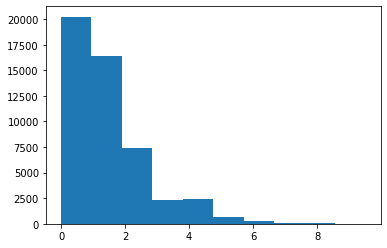

In [223]:
plt.hist(gene_score_total['score_total'])

# L1: 6.5 < x <= max in [5, 6] #about 152
# L2: 5 < x <= 6.5 in [4, 5] #about 710
# L3: 3.5 < x <= 5 in [3, 4] #about 4118
# L4: 2 < x <= 3.5 in [2, 3] #about 7308
# L5: 1 < x <= 2 in [1, 2] #about 16505
# L6: 0 < x <= 1 in [0, 1] #about 21043

In [245]:
# L1 rescaling
upper_b = 6
lower_b = 5
max_val = gene_score_total['score_total'].max()
min_val = 6.5

gene_score_total_L1 = gene_score_total[(gene_score_total['score_total'] > min_val) & (gene_score_total['score_total'] <= max_val)].reset_index().drop(['index'], axis = 1)
gene_score_total_L1['score'] = gene_score_total_L1['score_total'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [246]:
# L2 rescaling
upper_b = 5
lower_b = 4
max_val = 6.5
min_val = 5

gene_score_total_L2 = gene_score_total[(gene_score_total['score_total'] > min_val) & (gene_score_total['score_total'] <= max_val)].reset_index().drop(['index'], axis = 1)
gene_score_total_L2['score'] = gene_score_total_L2['score_total'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [247]:
# L3 rescaling
upper_b = 4
lower_b = 3
max_val = 5
min_val = 3.5

gene_score_total_L3 = gene_score_total[(gene_score_total['score_total'] > min_val) & (gene_score_total['score_total'] <= max_val)].reset_index().drop(['index'], axis = 1)
gene_score_total_L3['score'] = gene_score_total_L3['score_total'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [248]:
# L4 rescaling
upper_b = 3
lower_b = 2
max_val = 3.5
min_val = 2

gene_score_total_L4 = gene_score_total[(gene_score_total['score_total'] > min_val) & (gene_score_total['score_total'] <= max_val)].reset_index().drop(['index'], axis = 1)
gene_score_total_L4['score'] = gene_score_total_L4['score_total'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [249]:
# L5 rescaling
upper_b = 2
lower_b = 1
max_val = 2
min_val = 1

gene_score_total_L5 = gene_score_total[(gene_score_total['score_total'] > min_val) & (gene_score_total['score_total'] <= max_val)].reset_index().drop(['index'], axis = 1)
gene_score_total_L5['score'] = gene_score_total_L5['score_total'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [250]:
# L6 rescaling
upper_b = 1
lower_b = 0
max_val = 1
min_val = 0

gene_score_total_L6 = gene_score_total[(gene_score_total['score_total'] > min_val) & (gene_score_total['score_total'] <= max_val)].reset_index().drop(['index'], axis = 1)
gene_score_total_L6['score'] = gene_score_total_L6['score_total'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [253]:
gene_score_total = pd.concat([gene_score_total_L1, gene_score_total_L2, gene_score_total_L3, gene_score_total_L4, gene_score_total_L5, gene_score_total_L6]).reset_index().drop(['index'], axis = 1)

In [255]:
gene_score_total.to_excel(r'C:\Users\edwar\Desktop\農藝\paper2\data collection\dna_layer_final.xlsx', index = False)